In [9]:
'''
Author: James Parkington
Date:   2023-03-31

This script uses the SchoolAttendance and Students classes to generate random datasets as dataframes, SQL tables and CSV files.
This first cell starts the SQLite3 instance and describes the dataset.

1. Write a query that shows all students that did not attend school on their birthday.
2. Write a query that shows the attendance rate for each grade level on days when it is the student's birthday in that grade level
'''

import numpy  as np
from datetime import date

from Classes.SchoolAttendance import SchoolAttendance
from Classes.Students         import Students
from Classes.Utilities        import *


load_sql() # Connects to `jane.db`, so subsequent cells can be run directly off of that SQLite database

# This variable allows the same student_ids to be repurposed for the Students class
attendance_class = SchoolAttendance(date(2023, 1, 1), 
                                    date(2023, 1, 31), 
                                    1000)

attendance = attendance_class()
students   = Students(attendance_class)()

In [10]:
%%sql
-- 1. Write a query that shows all students that did not attend school on their birthday.

/*                                                            
DESCRIPTION                                             
  This query retrieves all students who did not attend school on their birthday.                                              
                                                                  
KEY DECISIONS                                                
  1. A regular JOIN is used instead of a LEFT JOIN, as we are only interested in records with matching rows in both tables.
  2. STRFTIME() is used with a single format specifier to concisely compare both the month and day components 
     of the `date_of_birth` and attendance `date`.                                                                     
*/

SELECT st.*,
       sa.date AS absence_date

  FROM students          st
  JOIN school_attendance sa USING (student_id)

 WHERE STRFTIME('%m-%d', st.date_of_birth) = STRFTIME('%m-%d', sa.date)
   AND NOT sa.attendance

 * sqlite:///../Data/jane.db
Done.


student_id,school_id,grade_level,gpa,date_of_birth,school_district,absence_date
1,SC5,6,2.71,2012-01-18,District 3,2023-01-18
103,SC3,1,2.94,2017-01-20,District 2,2023-01-20
201,SC4,10,3.0,2008-01-26,District 2,2023-01-26
397,SC2,9,2.72,2009-01-09,District 1,2023-01-09
508,SC1,1,3.16,2017-01-24,District 1,2023-01-24
515,SC6,5,2.95,2013-01-25,District 3,2023-01-25
536,SC4,7,2.71,2011-01-24,District 2,2023-01-24
547,SC4,2,3.17,2016-01-28,District 2,2023-01-28
772,SC5,3,2.91,2015-01-09,District 3,2023-01-09
846,SC2,8,3.25,2010-01-27,District 1,2023-01-27


In [11]:
# Takes the SQL output from the previous cell and immediately converts it to a pandas DataFrame
question_1 = _.DataFrame()

In [12]:
%%sql
-- 2. Write a query that shows the attendance rate for each grade level on days when it is the student's birthday in that grade level.

/*
DESCRIPTION
  This query calculates the attendance rate for each grade level on days when it is the student's birthday in that grade level.

KEY DECISIONS
  1. A CTE is used to simplify the calculations of attended and total birthday students in each grade level.
  2. WINDOW functions are used within the CTE to calculate both the SUM and COUNT in a single pass, potentially improving performance.
  3. STRFTIME() is used with a single format specifier to concisely compare both the month and day components of the 
     `date_of_birth` and attendance dates.
  4. SELECT DISTINCT is used to simplify the final result, since the operational fields are generated with a WINDOW function.
  5. Explicitly converting `bday_attendees` to a float using the `CAST` function avoids integer division when dividing 
     by `total_bdays`.

  Generally, I like to calculate arithmetic operations on facts once whenever possible, and then I let the final result 
  handle intra-field calculations

NOTE
  In this exercise, each question is answered in isolation. 
  In a production context, we would typically use CTEs or upstream view creation for the common transformations 
  across each business question using these schema.
  (e.g., joining `students` and `school_attendance`, comparing st.`date_of_birth` to sa.`date`, etc.)
*/

    WITH birthday_attendance AS
 (SELECT grade_level,
         attendance,
         SUM(attendance) OVER gl AS bday_attendees,
         COUNT(*)        OVER gl AS total_bdays

    FROM students          
    JOIN school_attendance USING (student_id)

   WHERE STRFTIME('%m-%d', date_of_birth) = STRFTIME('%m-%d', date)
  WINDOW gl AS (PARTITION BY grade_level))
--------
--------
  SELECT DISTINCT 
         grade_level,
         total_bdays,
         bday_attendees,
         ROUND(CAST(bday_attendees AS FLOAT) / total_bdays * 100, 2) AS attendance_rate

    FROM birthday_attendance
   ORDER BY 1

 * sqlite:///../Data/jane.db
Done.


grade_level,total_bdays,bday_attendees,attendance_rate
1,7,3,42.86
2,4,3,75.0
3,3,2,66.67
4,8,7,87.5
5,8,6,75.0
6,8,7,87.5
7,9,8,88.89
8,3,2,66.67
9,8,7,87.5
10,6,5,83.33


In [13]:
# Takes the SQL output from the previous cell and immediately converts it to a pandas DataFrame
question_2 = _.DataFrame()

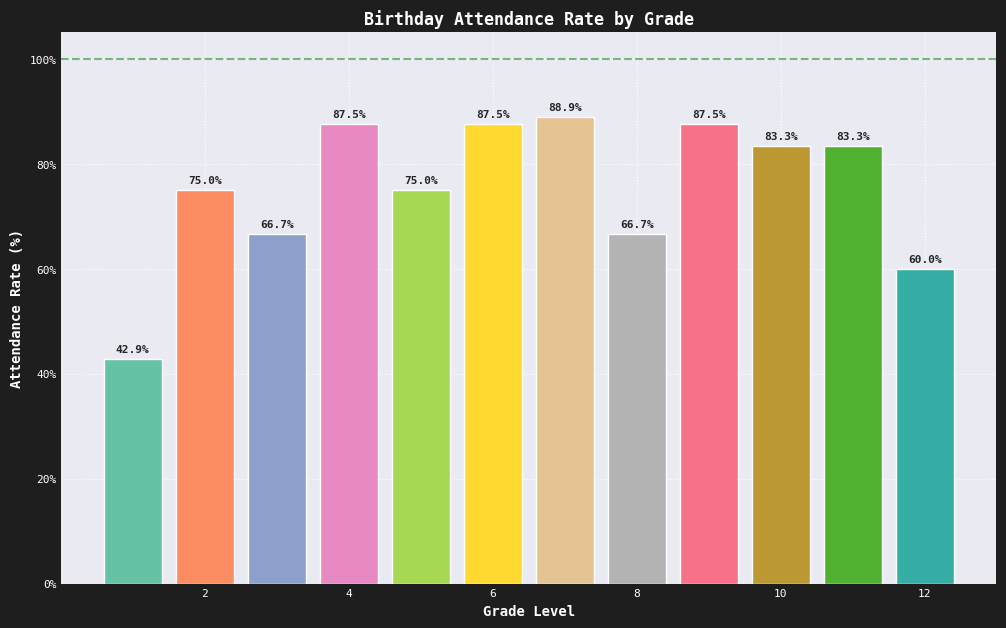

In [14]:
'''
Birthday Attendance Rate by Grade
Visualizes the relationship between the grade level and attendance rate using a bar chart.

A bar chart was chosen for this high-level analysis because it allows for an easy comparison of attendance rates
across different grade levels. It provides a clear visualization of how attendance rates differ by
grade, revealing potential areas of concern or interest that may warrant further investigation.

This analysis uses a `load_plot` utility function to apply a custom dark style and common customizations
to the pyplot output.
'''

# Load the custom plot settings
plot, axes, colors = load_plot()

# Prepare the data
grades          = question_2['grade_level']
attendance_rate = question_2['attendance_rate']

# Create the bar chart
bars = plot.bar(grades, 
                attendance_rate, 
                color     = colors, 
                edgecolor = 'white')

# Set the labels and titles
plot.xlabel('Grade Level')
plot.ylabel('Attendance Rate (%)')
plot.title('Birthday Attendance Rate by Grade')

# Customize the plot appearance
axes.set_ylim(0, 105)

# Add a transparent green constant line at 100% on the y-axis
axes.axhline(y         = 100,
             color     = 'green', 
             linestyle = '--', 
             alpha     = 0.5)

# Format the y-axis as a percentage
axes.yaxis.set_major_formatter(lambda x, pos: f'{x:.0f}%')

# Add percentage labels to each bar
for bar, value in zip(bars, attendance_rate):
    height = bar.get_height()
    axes.annotate(f'{value:.1f}%',
                xy         = (bar.get_x() + bar.get_width() / 2, height),
                xytext     = (0, 5),
                textcoords = "offset points",
                ha         = 'center', 
                fontsize   = 8,
                fontweight = 'bold') 

plot.show()

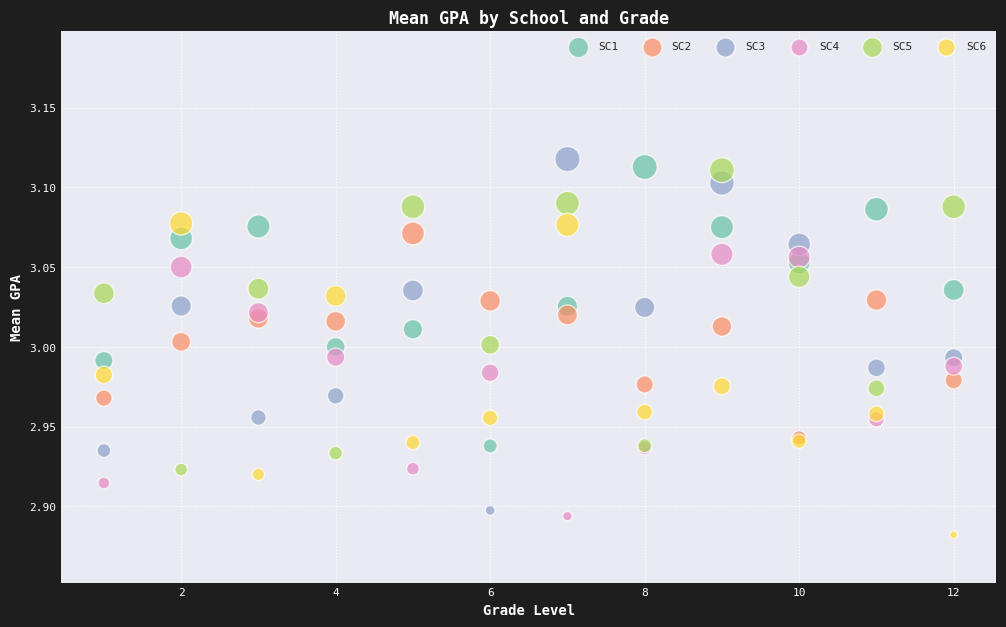

In [15]:
'''
Mean GPA by School and Grade
Visualizes the distribution of mean GPA by school using a scatter plot.

A scatter plot is an appropriate choice for visualizing the relationship between grade level and mean GPA across 
different schools. This is because a scatter plot effectively displays individual data points across two axes, 
revealing potential trends, correlations, or outliers.

This analysis uses a `load_plot` utility function to apply a custom dark style and common customizations
to the pyplot output.
'''

# Load the custom plot settings
plot, axes, colors = load_plot()

# Create the scatter plot with different colors for each school
mean_gpa        = students.groupby(['school_id', 'grade_level'])['gpa'].mean().reset_index()
unique_schools  = mean_gpa['school_id'].unique()
scatter_handles = []

# Calculate the marker sizes based on proximity to min[gpa] and max[gpa]
min_gpa, max_gpa        = mean_gpa['gpa'].min(), mean_gpa['gpa'].max()
marker_scaling_factor   = 300
marker_base_size        = 30
mean_gpa['marker_size'] = ((mean_gpa['gpa'] - min_gpa) / (max_gpa - min_gpa)) * marker_scaling_factor + marker_base_size

for i, school_id in enumerate(unique_schools):
    school_data  = mean_gpa[mean_gpa['school_id'] == school_id]
    scatter_plot = plot.scatter(school_data['grade_level'], 
                                school_data['gpa'], 
                                color      = colors[i], 
                                label      = school_id, 
                                alpha      = 0.7, 
                                edgecolors = "white",
                                s          = school_data['marker_size'])
    
    scatter_handles.append(scatter_plot)

# Set the labels and titles
plot.xlabel('Grade Level')
plot.ylabel('Mean GPA')
plot.title('Mean GPA by School and Grade')

# Customize the plot appearance
axes.set_ylim(min_gpa - 0.03, max_gpa + 0.08)

# Use the existing scatter plot handles for the legend
plot.legend(handles = scatter_handles, ncol = len(unique_schools))

plot.show()

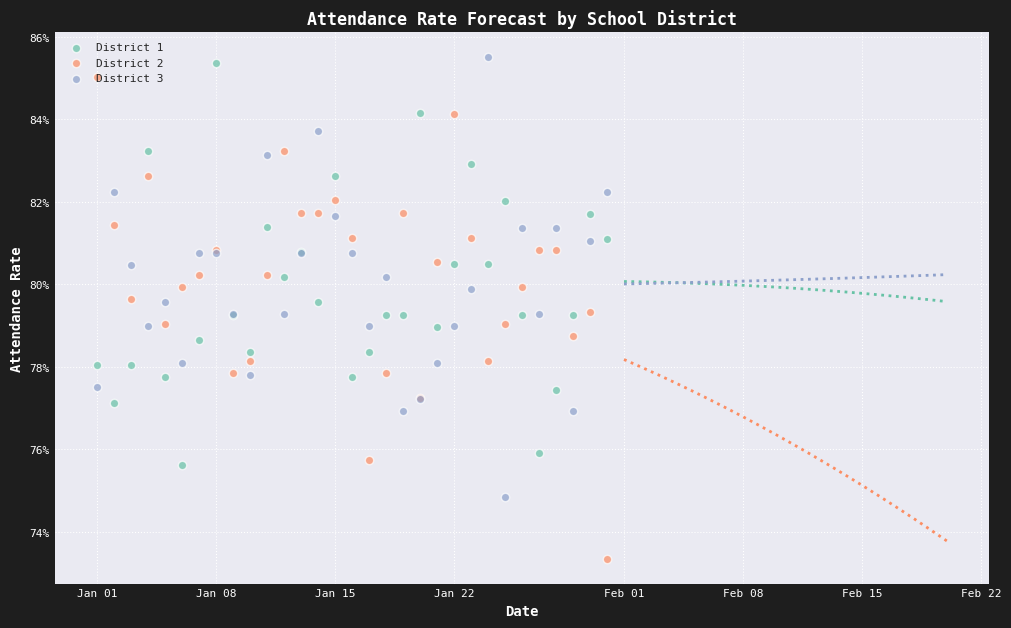

In [16]:
"""
Attendance Rate Forecast by School District

This script generates a plot of the attendance rate over time for each school district.
The actual attendance rates are displayed as scatter points, while the forecast is shown
as a series of lines. The forecast is created using Ridge regression with polynomial
features of degree 2. Ridge regression is a type of regularized linear regression that
penalizes large coefficients by adding a regularization term to the loss function.

In this script, an alpha value of 500 is chosen for Ridge regression due to the dataset
having a high level of noise. A high alpha value reduces the sensitivity of the model 
to small variations in the data and helps prevent overfitting.

Polynomial features of degree 2 are used to model the non-linear relationship between
the dependent variable (attendance rate) and the independent variable (time). This
approach provides a more accurate representation of the data compared to a simple linear
regression.

The actual attendance rate data points are plotted with an alpha of 0.7, making them
slightly translucent to emphasize the forecast lines. The forecast extends 20 days into
the future and displays only the lines without markers, providing a clear and concise
visual representation of the predicted trends in attendance rates.
"""

plot, axes, colors = load_plot()

grouped_data = pd.merge(attendance, students, on='student_id') \
                 .groupby(['school_district', 'date'])['attendance'] \
                 .mean() \
                 .reset_index()

for i, district in enumerate(grouped_data['school_district'].unique()):
    district_data = grouped_data[grouped_data['school_district'] == district]
    
    # Plot actual attendance rate with markers and predicted attendance rate as dashed lines
    plot.scatter(district_data['date'], 
                 district_data['attendance'], 
                 color      = colors[i], 
                 label      = district, 
                 alpha      = 0.7, 
                 edgecolors = "white")
    
    plot.plot(*polynomial_regression(district_data['date'],
                                     district_data['attendance']),
              color     = colors[i], 
              linestyle = ':', 
              linewidth = 2)

# Format the x-axis as string dates and the y-axis as percentages
axes.xaxis.set_major_formatter(lambda x, pos: pd.to_datetime(x, unit = 'D').strftime('%b %d'))
axes.yaxis.set_major_formatter(lambda x, pos: f'{x * 100:.0f}%')

axes.set_xlabel('Date')
axes.set_ylabel('Attendance Rate')
axes.set_title('Attendance Rate Forecast by School District')
plot.legend(loc = 'upper left')
plt.show()